In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
%matplotlib inline

# Utilitary functions

In [2]:
def show_images(im1, im2, title1, title2, gray=False):
    _, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(im1, cmap='gray' if gray else None)
    axes[0].axis('off')
    axes[0].set_title(f'Cathedral 1: {title1}')
    axes[1].imshow(im2, cmap='gray' if gray else None)
    axes[1].axis('off')
    axes[1].set_title(f'Cathedral 2: {title2}')

In [3]:
# To convert image to grayscale
def rgb2gray(rgb): 
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Import images

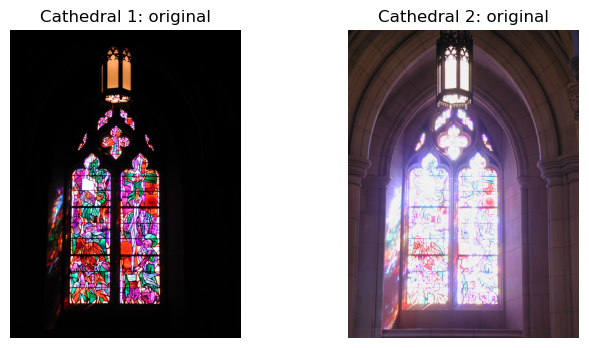

In [4]:
im1 = plt.imread("dataset/cathedral1.jpg")  # Here encoded as 8-byte image (0-255)
im2 = plt.imread("dataset/cathedral2.jpg")
show_images(im1, im2, 'original', 'original')

# Guided filter

In [5]:
# Credit for these functions goes to Julie Delon, Lucía Bouza and Joan Alexis Glaunès

def average_filter(u,r):    # implementation with integral images
    # uniform filter with a square (2*r+1)x(2*r+1) window
    # u is a 2d image
    # r is the radius for the filter

    (nrow, ncol)                                      = u.shape
    big_uint                                          = np.zeros((nrow+2*r+1,ncol+2*r+1))
    big_uint[r+1:nrow+r+1,r+1:ncol+r+1]               = u
    big_uint                                          = np.cumsum(np.cumsum(big_uint,0),1)       # integral image

    out = big_uint[2*r+1:nrow+2*r+1,2*r+1:ncol+2*r+1] + big_uint[0:nrow,0:ncol] - big_uint[0:nrow,2*r+1:ncol+2*r+1] - big_uint[2*r+1:nrow+2*r+1,0:ncol]
    out = out/(2*r+1)**2

    return out

def guided_filter(u,guide,r,eps):
    """Guided filtering on image u using guide, filter radius is r and regularization parameter eps"""
    C           = average_filter(np.ones(u.shape), r)   # to avoid image edges pb
    mean_u      = average_filter(u, r)/C
    mean_guide  = average_filter(guide, r)/C
    corr_guide  = average_filter(guide*guide, r)/C
    corr_uguide = average_filter(u*guide, r)/C
    var_guide   = corr_guide - mean_guide * mean_guide
    cov_uguide  = corr_uguide - mean_u * mean_guide

    alph = cov_uguide / (var_guide + eps)
    beta = mean_u - alph * mean_guide

    mean_alph = average_filter(alph, r)/C
    mean_beta = average_filter(beta, r)/C

    q = mean_alph * guide + mean_beta
    return q

# Image fusion with guided filtering

## Two-scale image decomposition

### Option 1 - Faster

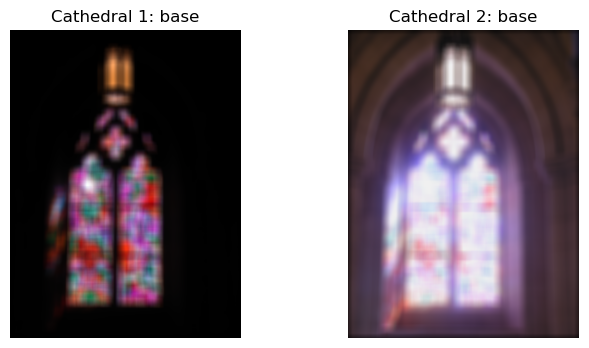

In [6]:
# Compute base layers
# Parameters
average_filter_size = 31

# For an average filter, we can apply the filter to each color channel separately
base1 = np.zeros_like(im1)
base2 = np.zeros_like(im2)
for i in range(3):
    base1[:,:,i] = average_filter(im1[:,:,i], average_filter_size)
    base2[:,:,i] = average_filter(im2[:,:,i], average_filter_size)
    
# Plot results
show_images(base1, base2, 'base', 'base')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


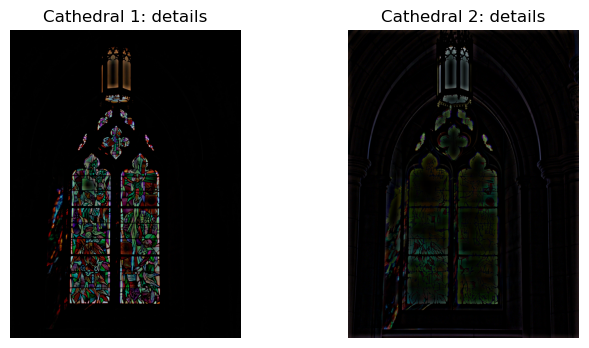

In [7]:
# Compute details layers
detail1 = im1.astype(int) - base1.astype(int)  # Convert to int to avoid uint8 overflow; remark: how to interpret negative values?
detail2 = im2.astype(int) - base2.astype(int)
    
# Plot results
show_images(detail1, detail2, 'details', 'details')

### Option 2 - much slower but more precise?

In [8]:
# # Compute base layers
# # Parameters
# average_filter_size = 31
# average_filter = np.ones((average_filter_size, average_filter_size)) / average_filter_size**2

# # For an average filter, we can apply the filter to each color channel separately
# base1 = np.zeros_like(im1)
# base2 = np.zeros_like(im2)
# for i in range(3):
#     base1[:,:,i] = convolve2d(im1[:,:,i], average_filter, mode='same')
#     base2[:,:,i] = convolve2d(im2[:,:,i], average_filter, mode='same')
    
# # Plot results
# show_images(base1, base2, 'base', 'base')

In [9]:
# # Compute details layers
# detail1 = im1.astype(int) - base1.astype(int)  # Convert to int to avoid uint8 overflow
# detail2 = im2.astype(int) - base2.astype(int)
    
# # Plot results
# show_images(detail1, detail2, 'details', 'details')

## Weight Map Construction With Guided Filtering

### Apply Laplacian filter

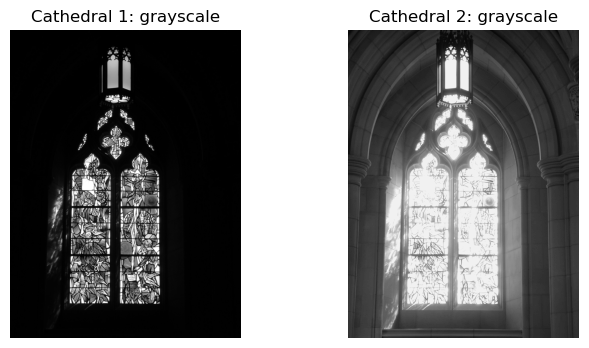

In [10]:
# We will convert images to grayscale to apply Laplacian filter
show_images(rgb2gray(im1), rgb2gray(im2), 'grayscale', 'grayscale', gray=True)

#### Option 1 - more detailed, but does not seem to work

In [11]:
# def laplacian_filter(image, sigma=1, size=3):
#     if size % 2 == 0:
#         size += 1

#     x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(-size//2+1, size//2+1))
#     kernel = (1/(2*np.pi*sigma**6))*(x**2 + y**2 - 2*sigma**2) * np.exp(-(x**2 + y**2) / (2*sigma**2))
#     kernel = kernel / np.sum(np.abs(kernel))

#     # Perform convolution
#     result = convolve2d(image, kernel)

#     return result

In [12]:
# # Parameters
# kernel_size = 3  # Size of the Laplacian kernel
# sigma = 1  # Standard deviation of the Gaussian kernel

# # Apply Laplacian filter
# H1 = laplacian_filter(rgb2gray(im1), sigma=sigma, size=kernel_size)
# H2 = laplacian_filter(rgb2gray(im2), sigma=sigma, size=kernel_size)
# H1 = np.abs(H1)
# H2 = np.abs(H2)
# show_images(H1, H2, 'Laplacian', 'Laplacian', gray=True)

#### Option 2 - more OpenCV

In [13]:
import cv2 as cv

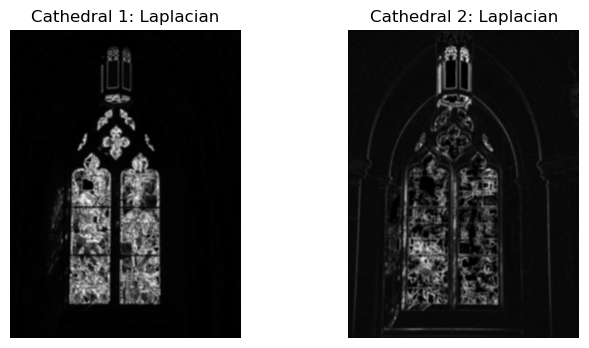

In [14]:
# Declare the variables we are going to use
ddepth = cv.CV_16S
kernel_size = 3
sigma = 0  # ?
local_average_size = 7

# Image 1
im1_blur = cv.GaussianBlur(im1, (kernel_size, kernel_size), sigma)
im1_gray = cv.cvtColor(im1_blur, cv.COLOR_BGR2GRAY)
H1 = cv.Laplacian(im1_gray, ddepth, ksize=kernel_size)
H1 = cv.convertScaleAbs(H1)
H1 = average_filter(H1, local_average_size)  # Take local average of the absolute value
# Image 2
im2_blur = cv.GaussianBlur(im2, (kernel_size, kernel_size), sigma)
im2_gray = cv.cvtColor(im2_blur, cv.COLOR_BGR2GRAY)
H2 = cv.Laplacian(im2_gray, ddepth, ksize=kernel_size)
H2 = cv.convertScaleAbs(H2)
H2 = average_filter(H2, local_average_size)

# Show images
show_images(H1, H2, 'Laplacian', 'Laplacian', gray=True)

### Apply low-pass Gaussian filter

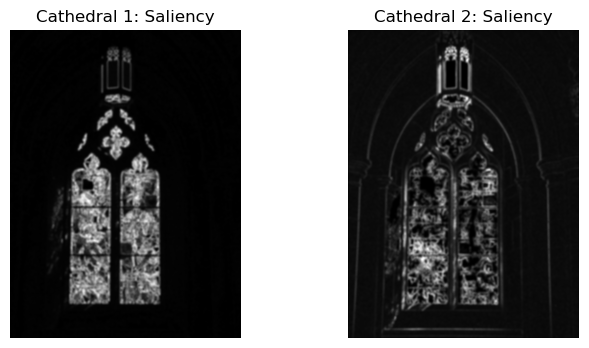

In [15]:
# Parameters
sigma = 5 # Standard deviation of the Gaussian kernel
radius = 5 # Radius of the Gaussian filter

# Compute saliency maps
saliency1 = gaussian_filter(H1, sigma=sigma, radius=radius)
saliency2 = gaussian_filter(H2, sigma=sigma, radius=radius)
show_images(saliency1, saliency2, 'Saliency', 'Saliency', gray=True)

### Get weight masks by saliency comparison

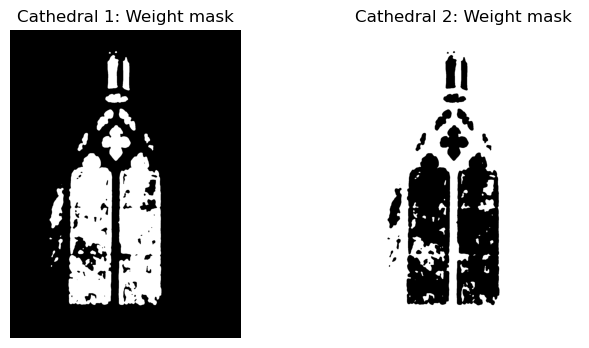

In [16]:
# Here implemented for only 2 images
P1 = (saliency1 >= saliency2).astype(int)
P2 = 1 - P1
show_images(P1, P2, 'Weight mask', 'Weight mask', gray=True)

### Guided Filtering on weight masks to obtain spatial consistency

In [17]:
def guided_filter_with_colored_guide(u,guide,r,eps):
    """ u is one channel of the image to be filtered. """
    mean_u = average_filter(u,r) #shape (w,h)
    mean_guide = np.zeros_like(guide)
    for i in range(guide.shape[2]):
        mean_guide[:,:,i] = average_filter(guide[:,:,i],r)
    
    corr_uguide = np.zeros_like(guide)
    for i in range(guide.shape[2]):
        corr_uguide[:,:,i] = average_filter(guide[:,:,i] * u,r)
    
    cov_uguide = corr_uguide - mean_guide * mean_u[:,:,None] #shape (w,h,3)

    corr_guide = (guide[:,:,:,None] - mean_guide[:,:,:,None]) * (guide[:,:,None,:] - mean_guide[:,:,None,:]) #shape (w,h,3,3)
    cov_guide = np.zeros_like(corr_guide)
    for i in range(guide.shape[2]):
        for j in range(guide.shape[2]):
            cov_guide[:,:,i,j] = average_filter(corr_guide[:,:,i,j],r)
    matU = eps * np.eye(3)
    
    # temp_alpha = cov_guide + matU[None,None,:,:]
    temp_alpha = np.linalg.inv(cov_guide + matU[None,None,:,:])
    alpha = np.einsum('whij,whj-> whi', temp_alpha, cov_uguide) #shape (w,h,3)
    
    beta = mean_u - np.einsum('whi,whi->wh', alpha, mean_guide) #shape (w,h)

    average_alpha = np.zeros_like(alpha)
    for i in range(alpha.shape[2]):
        average_alpha[:,:,i] = average_filter(alpha[:,:,i],r)
    average_beta = average_filter(beta, r)

    q = np.einsum('whi, whi -> wh', average_alpha, guide) + average_beta
    return q


In [25]:
r1 = 45
r2 = 7
eps1 = 0.3
eps2 = 1e-6
W1B = guided_filter_with_colored_guide(P1, im1, r1, eps1)
W2B = guided_filter_with_colored_guide(P2, im2, r1, eps1)
show_images(W1B, W2B, 'Weight mask for base', 'Weight mask for base', gray=True)
W1D = guided_filter_with_colored_guide(P1, im1, r2, eps2)
W2D = guided_filter_with_colored_guide(P2, im2, r2, eps2)
show_images(W1D, W2D, 'Weight mask for detail', 'Weight mask for detail', gray=True)



KeyboardInterrupt: 

#### Guided filter from opencv

In [63]:
W2D

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

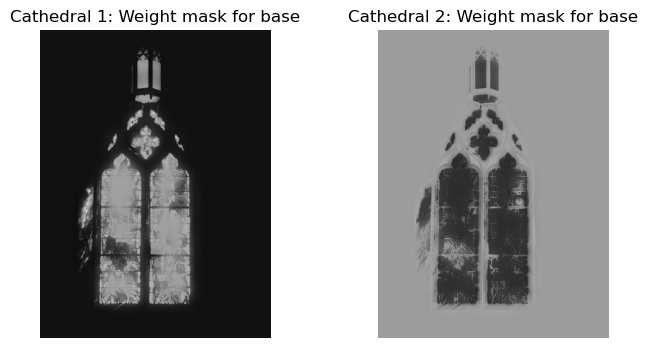

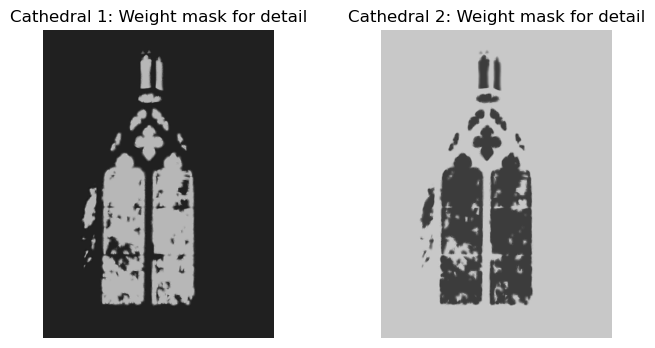

In [62]:
from cv2.ximgproc import guidedFilter

# Convert images into uint8
P1 = np.uint8(P1)
P2 = np.uint8(P2)

# Apply filters
r1 = 45
r2 = 7
eps1 = 0.3
eps2 = 1e-6
W1B = guidedFilter(im1, P1, r1, eps1)
W2B = guidedFilter(im2, P2, r1, eps1)
show_images(W1B, W2B, 'Weight mask for base', 'Weight mask for base', gray=True)
W1D = guidedFilter(im1, P1, r2, eps2)
W2D = guidedFilter(im2, P2, r2, eps2)
show_images(W1D, W2D, 'Weight mask for detail', 'Weight mask for detail', gray=True)

### Reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


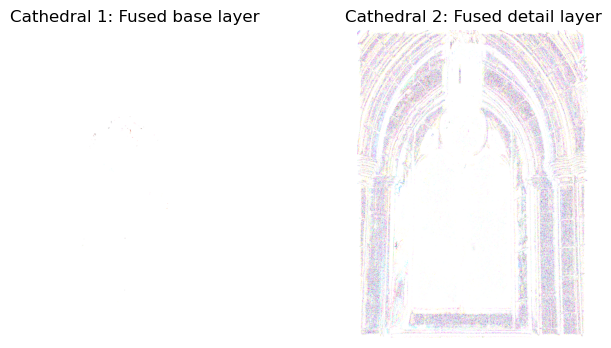

In [64]:
fusedB = W1B[:,:,None] * base1 + W2B[:,:,None] * base2
fusedD = W1B[:,:,None] * detail1 + W2B[:,:,None] * detail2
show_images(fusedB, fusedD, 'Fused base layer', 'Fused detail layer')

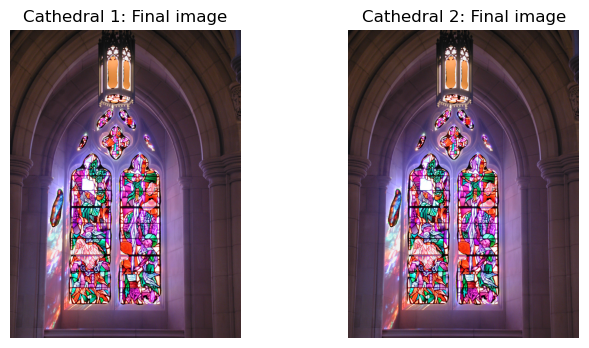

In [40]:
final_img = fusedB + fusedD
show_images(final_img, final_img, 'Final image', 'Final image')